


<p style="font-size:36px;text-align:center"> <b>Personalized cancer diagnosis</b> </p>

- ## Imports

In [440]:
import time
import re
import math

import numpy as np
import pandas as pd
from scipy.sparse import hstack
import scipy.sparse as sp

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter,defaultdict
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss

- ## Reading Data

In [2]:
d1 = pd.read_csv('datasets/training_variants',index_col='ID')
d2 = pd.read_csv('datasets/training_text',sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1,index_col='ID') # to know more about the engine visit the documnetation for .read_csv() also sep="\|\|" as the seperatop for this text file is || 
data = pd.concat([d1,d2],axis=1)

In [3]:
data.info()

&lt;class &#39;pandas.core.frame.DataFrame&#39;&gt;
Int64Index: 3321 entries, 0 to 3320
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Gene       3321 non-null   object
 1   Variation  3321 non-null   object
 2   Class      3321 non-null   int64 
 3   TEXT       3316 non-null   object
dtypes: int64(1), object(3)
memory usage: 129.7+ KB


In [4]:
data[data.isna().any(axis=1)] # here any() searches for any true value in the columns but any(1) searches for true values in each row

,Gene,Variation,Class,TEXT
ID,,,,
1109,FANCA,S1088F,1,NaN
1277,ARID5B,Truncating Mutations,1,NaN
1407,FGFR3,K508M,6,NaN
1639,FLT1,Amplification,6,NaN
2755,BRAF,G596C,7,NaN


We are not goinng to fill the missing nan values as we have taken care of the nan value sin the text preprosessing function

In [5]:
data['Gene'].value_counts()

BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
         ... 
EPCAM       1
FAM58A      1
IKZF1       1
DUSP4       1
EIF1AX      1
Name: Gene, Length: 264, dtype: int64

In [6]:
data['Variation'].value_counts()

Truncating Mutations    93
Deletion                74
Amplification           71
Fusions                 34
Overexpression           6
                        ..
G248V                    1
E453A                    1
X1007_splice             1
R1231Q                   1
S1733F                   1
Name: Variation, Length: 2996, dtype: int64

In [7]:
data['Class'].value_counts(normalize=True)

7    0.286962
4    0.206564
1    0.171033
2    0.136104
6    0.082806
5    0.072870
3    0.026799
9    0.011141
8    0.005721
Name: Class, dtype: float64

&lt;AxesSubplot:ylabel=&#39;Class&#39;&gt;

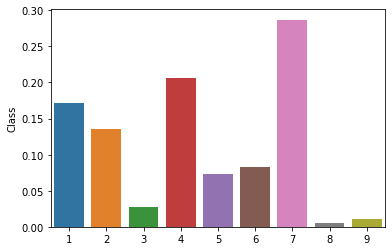

In [8]:
sns.barplot(data['Class'].value_counts(normalize=True).index,data['Class'].value_counts(normalize=True))

- ## Text Preprocessing

In [9]:
STOP_WORDS = stopwords.words('english')
def TextPreprocessing(txt):
    if str(txt) != 'nan':
        txt = re.sub(r'[^A-Za-z0-9]+',' ',txt)
        txt = re.sub('\s+',' ',txt)
        txt = txt.lower()
        wrds = [w for w in txt.split() if w not in STOP_WORDS]
        txt_str = ' '.join(str(e) for e in wrds)
        return txt_str
    else: return ' '

In [10]:
start_time = time.time()
data['txt'] = data['TEXT'].apply(TextPreprocessing)
print('Time took for preprocessing the text :',time.time() - start_time, "seconds")

Time took for preprocessing the text : 93.43663763999939 seconds


In [11]:
data.Gene      = data.Gene.str.replace('\s+', '_')
data.Variation = data.Variation.str.replace('\s+', '_')

- ## Train Test CV split {64,20,16} 
 Randomly

In [12]:
trainX,testx,trainY,testy = train_test_split(data.drop(['TEXT'],axis=1),data['Class'],stratify=data['Class'],test_size=0.2)
trainx,cvx,trainy,cvy = train_test_split(trainX,trainY,stratify=trainY,test_size=0.2)

In [13]:
trainy.value_counts(normalize=True),testy.value_counts(normalize=True),cvy.value_counts(normalize=True)

(7    0.286723
 4    0.206685
 1    0.170904
 2    0.136064
 6    0.082863
 5    0.072976
 3    0.026836
 9    0.011299
 8    0.005650
 Name: Class, dtype: float64,
 7    0.287218
 4    0.206015
 1    0.171429
 2    0.136842
 6    0.082707
 5    0.072180
 3    0.027068
 9    0.010526
 8    0.006015
 Name: Class, dtype: float64,
 7    0.287594
 4    0.206767
 1    0.171053
 2    0.135338
 6    0.082707
 5    0.073308
 3    0.026316
 9    0.011278
 8    0.005639
 Name: Class, dtype: float64)

In [14]:
trainy.shape,testy.shape,cvy.shape

((2124,), (665,), (532,))

- ### Creating an Random model
Now why creating an random model is important?

> Ans) Here we are using 'LogLoss' as Key Preformance Indicator/ Metric, so we do not have an base line to compare our model to.
As in AUROC we know that the score should lie within 0.5 to 1 and if the model is close to 0.5 the model is as good as random model, which predicts randomly. But the LogLoss lie in [0,infinity), so we know that the model is best when it is colse to zero, but we do not have any parameter to compare our model with like in AUROC the 0.5 is the baseline score.<br>
  &nbsp&nbsp&nbsp&nbsp&nbsp    So to get the baseline we will create an random model. Consider that 0.8 is the score we get from random model. Now we know that the score of our model should lie less than 0.8 ,if the loggloss of our model is more than 0.8 then our model is worst than the random model, which is not good. 

In [15]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum

# Getting the test score
np.random.seed(99)
rand_probs = np.random.rand(len(testy),9)
rand_y_probs = [x/sum(x) for x in rand_probs]
print("Log loss on Cross Validation Data using Random Model",log_loss(testy,rand_y_probs,eps=1e-15))

Log loss on Cross Validation Data using Random Model 2.3939064036392663


### Therefore our LogLoss should lie between [ 0,2.49 ]

- # Univariante Analysis

## 1)Genes

In [16]:
data['Gene'].describe(),data['Gene'].value_counts()

(count      3321
 unique      264
 top       BRCA1
 freq        264
 Name: Gene, dtype: object,
 BRCA1     264
 TP53      163
 EGFR      141
 PTEN      126
 BRCA2     125
          ... 
 EPCAM       1
 FAM58A      1
 IKZF1       1
 DUSP4       1
 EIF1AX      1
 Name: Gene, Length: 264, dtype: int64)

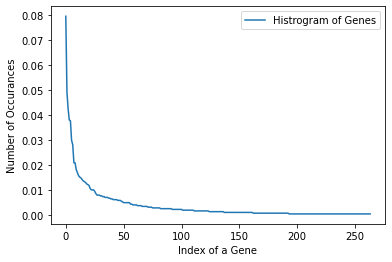

In [17]:
plt.plot(data['Gene'].value_counts(normalize=True).to_numpy(),label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.show()

<h3> As we can see the above distribution is right skewed and also very first few genes occur large times than the rest of other

- ### CDF Distribution

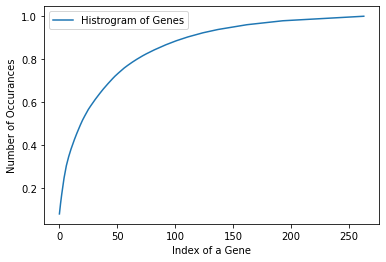

In [18]:
plt.plot(np.cumsum(data['Gene'].value_counts(normalize=True).to_numpy()),label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.show()

<h3> as we can see here with only first most occuring 50 Genes almost 80% of data gets covered

- ### Now to vectorize the Categorical variable we have two options:
<h3> 1) One Hot Encoding <br>
2)Response Coding </h3>

Here First we will try response coding

In [19]:
def getResProbs(grp_col,a): # A stands for alpha in Laplace Smoothing
    temp = grp_col.value_counts()
    res_cols = list()
    tot = temp.sum()
    for i in range(1,10):
        if i not in temp.index:
            res_cols.append((10*a)/(tot+(90*a)))
        else:
            res_cols.append((temp[i]+(10*a))/(tot+(90*a)))
    return res_cols

res_dict = dict(trainx.groupby('Gene')['Class'].apply(lambda x:getResProbs(x,1)))

def mappResDict(x,dict):
    if x in dict.keys():
        return dict[x]
    else:
        return [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9]

In [20]:
train_gene_response=pd.DataFrame(list(trainx['Gene'].apply(lambda x:mappResDict(x,res_dict))),index=trainx.index,columns=list(range(1,10)))
test_gene_response = pd.DataFrame(list(testx['Gene'].apply(lambda x:mappResDict(x,res_dict))),index=testx.index,columns=list(range(1,10)))
cv_gene_response = pd.DataFrame(list(cvx['Gene'].apply(lambda x:mappResDict(x,res_dict))),index=cvx.index,columns=list(range(1,10)))

 ### One Hot Encoding
 

In [205]:
OHE_gene = OneHotEncoder(sparse=0,handle_unknown='ignore')
OHE_gene.fit(trainx['Gene'].to_numpy().reshape(-1,1))
train_gene_ohe = OHE_gene.transform(trainx['Gene'].to_numpy().reshape(-1,1))
test_gene_ohe = OHE_gene.transform(testx['Gene'].to_numpy().reshape(-1,1))
cv_gene_ohe = OHE_gene.transform(cvx['Gene'].to_numpy().reshape(-1,1))
train_gene_ohe.shape,test_gene_ohe.shape,cv_gene_ohe.shape

((2124, 227), (665, 227), (532, 227))

In the above cell we had to put handle_unknown='ignore' as not all Gene categories are present in the train data and when we transform the test&cv data an error get thrown saying that they have encountered an unknown category. So we have two options <br>
1) use handle_unknown='ignore' , so all the unknown categories are presented ad [0,0,0,...] <b>(Cell ABOVE)</b><br>
2) fit the onehot encoder on the whole data set so that it has all the categories and then transform train,test and cv. which is totally wrong as it causes data leckage, but we have done this in case of DonersChoose dataset in NB.ipynb.<b>(Cell BELOW)</b> 

In [22]:
# OHE = OneHotEncoder(sparse=0)
# OHE.fit(data['Gene'].to_numpy().reshape(-1,1))
# train_gene_ohe = OHE.transform(trainx['Gene'].to_numpy().reshape(-1,1))
# test_gene_ohe = OHE.transform(testx['Gene'].to_numpy().reshape(-1,1))
# cv_gene_ohe = OHE.transform(cvx['Gene'].to_numpy().reshape(-1,1))
# train_gene_ohe.shape,test_gene_ohe.shape,cv_gene_ohe.shape

<p style="font-size:18px;"> <b>Q.</b> How good is this gene feature  in predicting y_i?</p><br>
There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Gene feature (one hot encoded) to predict y_i.

- <h3> Creating model for <font color=red> Gene </font> feature </h3>

First we will create the function for Confusion matrix

In [23]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

### Logistic Classification on Gene

100%|██████████| 7/7 [00:01&lt;00:00,  5.80it/s]
Test log losses: [1.2356653866831, 1.2066079630582023, 1.243556327279594, 1.3441893835022605, 1.3970524902865242, 1.4224442414141096, 1.452666412031045]
Best alpha: 0.0001
Train Log-loss: 0.9896937869440446
CV Log-loss: 1.1635197588248856
Test Log-loss: 1.2066079630582023
-------------------- Confusion matrix --------------------


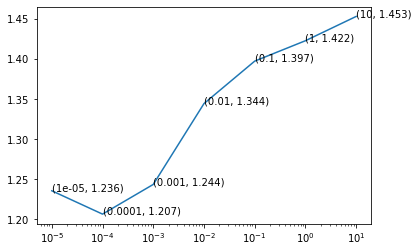

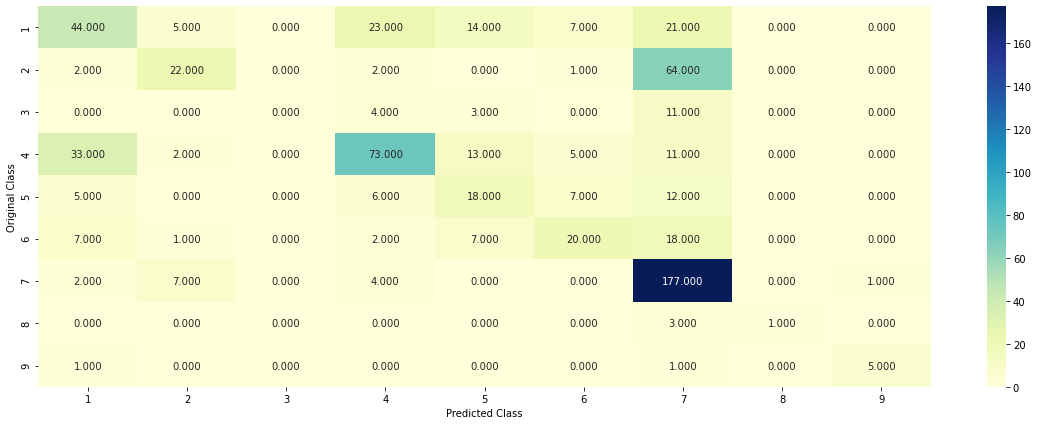

-------------------- Precision matrix (Columm Sum=1) --------------------


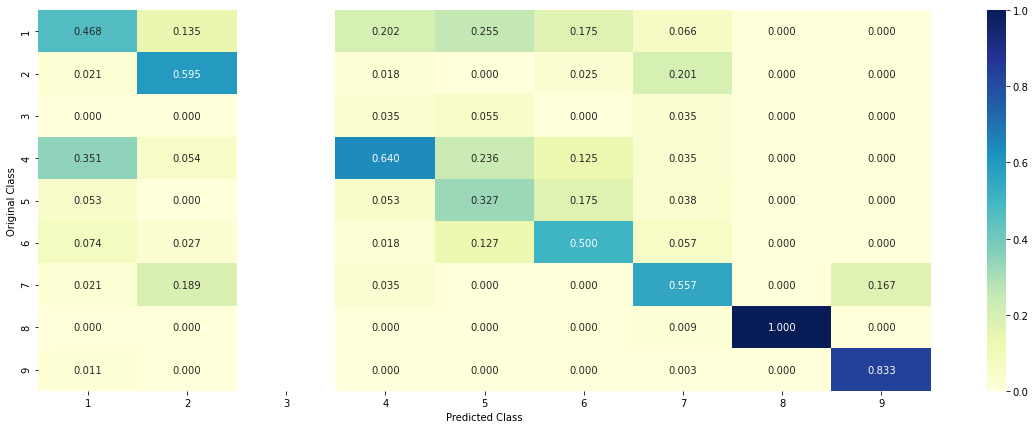

-------------------- Recall matrix (Row sum=1) --------------------


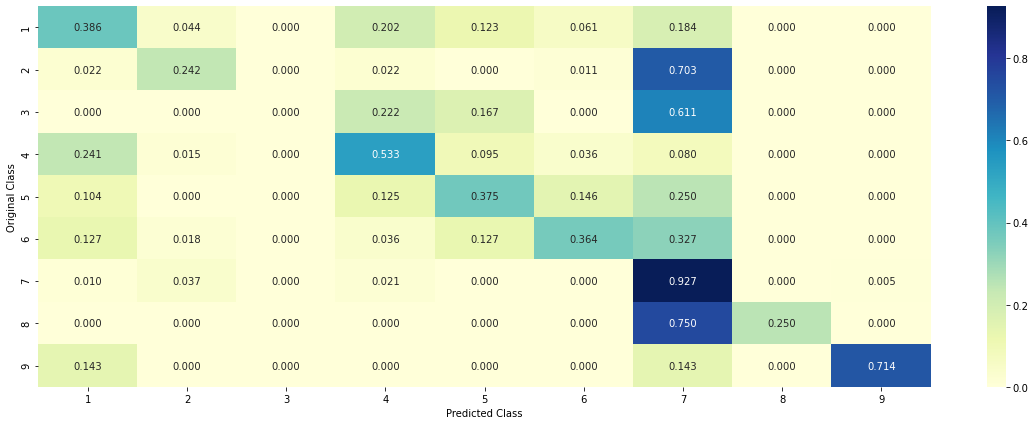

In [24]:
# Logistic classification With method='sigmoid' in CalibratedClassifierCV
log_loss_Logi = []
alphas = [10 ** x for x in range(-5,2)]
for alpha in tqdm(alphas):
    log_clf = SGDClassifier(loss='log',penalty='l2',alpha=alpha,random_state=99,n_jobs=-1)
    log_clf.fit(train_gene_ohe,trainy)
    log_calib = CalibratedClassifierCV(log_clf,method='sigmoid',cv='prefit')
    log_calib.fit(cv_gene_ohe,cvy)
    Y_predict_log = log_calib.predict_proba(test_gene_ohe)
    log_loss_Logi.append(log_loss(testy,Y_predict_log,eps=1e-15))
''' We should be doing the CV here as we are using the Y_test for getting the best apha which is totally wrong'''
print('Test log losses:',log_loss_Logi)
# plt.plot(alphas,log_loss_Logi) #matplotlib
# plt.show()
sns.lineplot(alphas,log_loss_Logi).set(xscale="log")
ax=plt.gca()
for i, txt in enumerate(np.round(log_loss_Logi,3)):
    ax.annotate((alphas[i],np.round(txt,3)), (alphas[i],log_loss_Logi[i]))

bst_alpha = alphas[log_loss_Logi.index(min(log_loss_Logi))]
bst_estimator_Logi = SGDClassifier(loss='log',penalty='l2',alpha=bst_alpha,random_state=99,n_jobs=-1)
bst_estimator_Logi.fit(train_gene_ohe,trainy)
bst_estimator_Logi_calib = CalibratedClassifierCV(bst_estimator_Logi,method='sigmoid',cv='prefit')
bst_estimator_Logi_calib.fit(cv_gene_ohe,cvy)
print('Best alpha:',bst_alpha)
print('Train Log-loss:',log_loss(trainy,bst_estimator_Logi_calib.predict_proba(train_gene_ohe),eps=1e-15))
print('CV Log-loss:',log_loss(cvy,bst_estimator_Logi_calib.predict_proba(cv_gene_ohe),eps=1e-15))
print('Test Log-loss:',log_loss(testy,bst_estimator_Logi_calib.predict_proba(test_gene_ohe),eps=1e-15))
plot_confusion_matrix(testy,bst_estimator_Logi.predict(test_gene_ohe))

In [25]:
print("Q. How many data points in Test and CV datasets are covered by the ", trainx['Gene'].value_counts().shape[0], " genes in train dataset?")

test_coverage=testx[testx['Gene'].isin(list(set(trainx['Gene'])))].shape[0]
cv_coverage=cvx[cvx['Gene'].isin(list(set(trainx['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',testx.shape[0], ":",(test_coverage/testx.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cvx.shape[0],":" ,(cv_coverage/cvx.shape[0])*100)

Q. How many data points in Test and CV datasets are covered by the  227  genes in train dataset?
Ans
1. In test data 630 out of 665 : 94.73684210526315
2. In cross validation data 513 out of  532 : 96.42857142857143


<p style="font-size:18px;"> <b>Q.</b> Is the Gene feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> First of all lets see what is stability of feature.<br> It should not happen that the categories of the feature that are present in train dataset are totally or significantly different from the categories in test and cv dataset. So for an feature to be stable most of it's categories should overlap between the different datasets. <br>
Here in the previous cell we can see that the feature's categories overlap significantly hence we can say it is STABLE. <br> Also it definitely, Otherwise, the CV and Test errors would be significantly more than train error. </p>

## 2)Variation Feature
<p>            &nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp in univariant analysis

In [26]:
data['Variation'].describe(),data['Variation'].value_counts()

(count                     3321
 unique                    2996
 top       Truncating_Mutations
 freq                        93
 Name: Variation, dtype: object,
 Truncating_Mutations    93
 Deletion                74
 Amplification           71
 Fusions                 34
 Overexpression           6
                         ..
 Y65C                     1
 I1170N                   1
 R130G                    1
 K2472T                   1
 S1733F                   1
 Name: Variation, Length: 2996, dtype: int64)

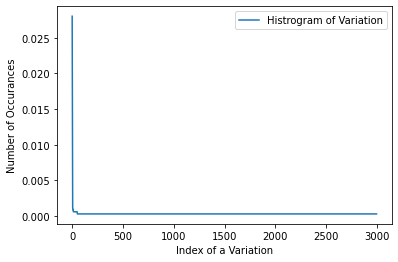

In [27]:
plt.plot(data['Variation'].value_counts(normalize=True).to_numpy(),label="Histrogram of Variation")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.show()

<h3> As we can see the above distribution is highly right skewed and also first very very few genes occur large times than the rest of other

- ### CDF Distribution

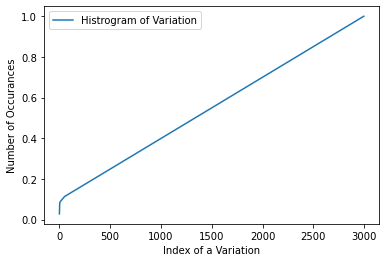

In [28]:
plt.plot(np.cumsum(data['Variation'].value_counts(normalize=True).to_numpy()),label="Histrogram of Variation")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.show()

<h3> as we can see here with only first most occuring 50 Genes almost 80% of data gets covered

- ### Now to vectorize the Categorical variable we have two options:
<h3> 1) One Hot Encoding <br>
2)Response Coding </h3>

Here First we will try response coding

In [29]:
res_dict = dict(trainx.groupby('Variation')['Class'].apply(lambda x:getResProbs(x,1)))
train_vari_response = pd.DataFrame(list(trainx['Variation'].apply(lambda x:mappResDict(x,res_dict))),index=trainx.index,columns=list(range(1,10)))
test_vari_response=pd.DataFrame(list(testx['Variation'].apply(lambda x:mappResDict(x,res_dict))),index=testx.index,columns=list(range(1,10)))
cv_vari_response = pd.DataFrame(list(cvx['Variation'].apply(lambda x:mappResDict(x,res_dict))),index=cvx.index,columns=list(range(1,10)))
train_vari_response.shape

(2124, 9)

 ### One Hot Encoding

In [203]:
OHE_vari = OneHotEncoder(sparse=0,handle_unknown='ignore')
OHE_vari.fit(trainx['Variation'].to_numpy().reshape(-1,1))
train_vari_ohe = OHE_vari.transform(trainx['Variation'].to_numpy().reshape(-1,1))
test_vari_ohe = OHE_vari.transform(testx['Variation'].to_numpy().reshape(-1,1))
cv_vari_ohe = OHE_vari.transform(cvx['Variation'].to_numpy().reshape(-1,1))
train_vari_ohe.shape,test_vari_ohe.shape,cv_vari_ohe.shape

((2124, 1951), (665, 1951), (532, 1951))

In the above cell we had to put handle_unknown='ignore' as not all Gene categories are present in the train data and when we transform the test&cv data an error get thrown saying that they have encountered an unknown category. So we have two options <br>
1) use handle_unknown='ignore' , so all the unknown categories are presented ad [0,0,0,...] <b>(Cell ABOVE)</b><br>
2) fit the onehot encoder on the whole data set so that it has all the categories and then transform train,test and cv. which is totally wrong as it causes data leckage, but we have done this in case of DonersChoose dataset in NB.ipynb.<b>(Cell BELOW)</b> 

In [31]:
# OHE = OneHotEncoder(sparse=0)
# OHE.fit(data['Variation'].to_numpy().reshape(-1,1))
# train_vari_ohe = OHE.transform(trainx['Variation'].to_numpy().reshape(-1,1))
# test_vari_ohe = OHE.transform(testx['Variation'].to_numpy().reshape(-1,1))
# cv_vari_ohe = OHE.transform(cvx['Variation'].to_numpy().reshape(-1,1))
# train_vari_ohe.shape,test_vari_ohe.shape,cv_vari_ohe.shape

<p style="font-size:18px;"> <b>Q.</b> How good is this Variation feature  in predicting y_i?</p><br>
There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Variation feature (one hot encoded) to predict y_i.

- <h3> Creating model for <font color=red> Variation </font> feature </h3>

### Logistic Classification on Variation

100%|██████████| 7/7 [00:02&lt;00:00,  2.89it/s]
Test log losses: [1.7302998951941038, 1.724862558765331, 1.723625501630068, 1.7277556873998081, 1.72834959298583, 1.7222903889154784, 1.722113275107996]
Best alpha: 10
Train Log-loss: 1.5821071740942412
CV Log-loss: 1.7104754538949283
Test Log-loss: 1.722113275107996
-------------------- Confusion matrix --------------------


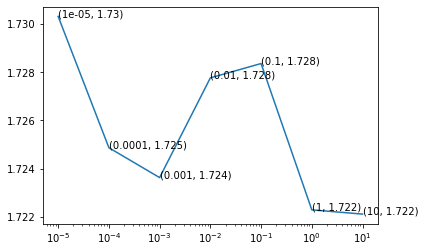

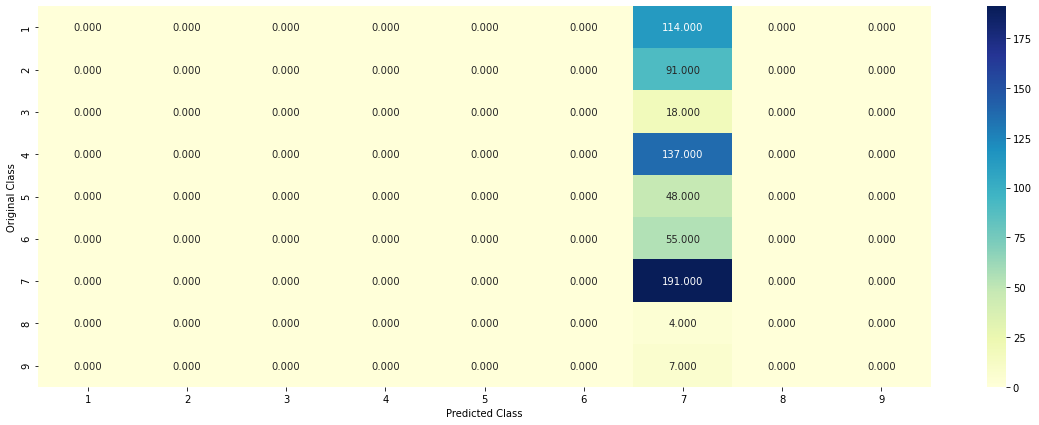

-------------------- Precision matrix (Columm Sum=1) --------------------


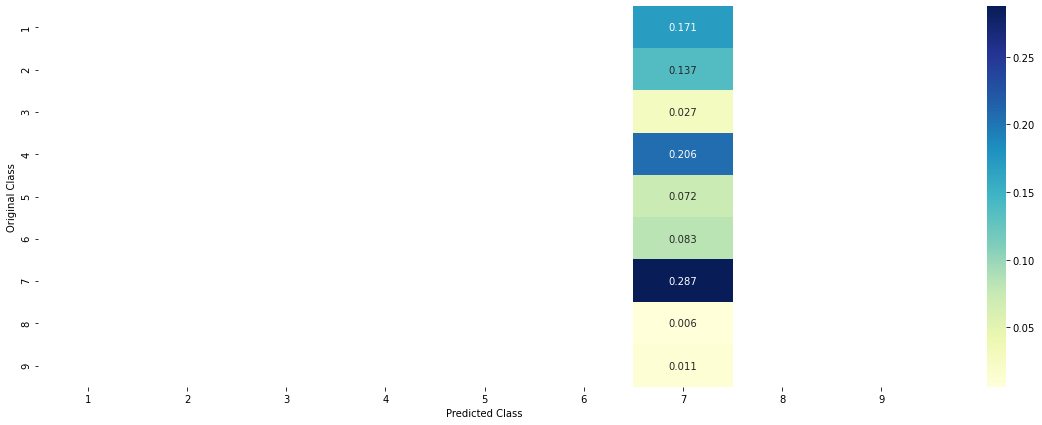

-------------------- Recall matrix (Row sum=1) --------------------


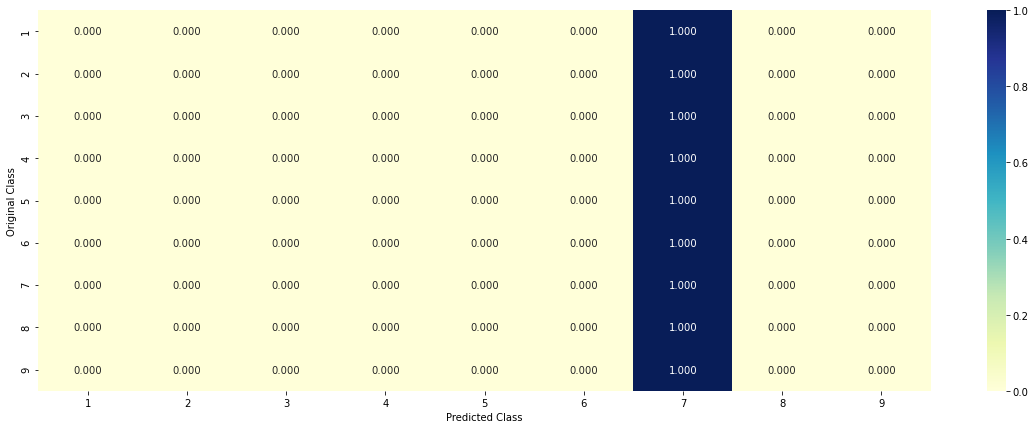

In [32]:
# Logistic classification With method='sigmoid' in CalibratedClassifierCV
log_loss_Logi = []
alphas = [10 ** x for x in range(-5,2)]
for alpha in tqdm(alphas):
    log_clf = SGDClassifier(loss='log',penalty='l2',alpha=alpha,random_state=99,n_jobs=-1)
    log_clf.fit(train_vari_ohe,trainy)
    log_calib = CalibratedClassifierCV(log_clf,method='sigmoid',cv='prefit')
    log_calib.fit(cv_vari_ohe,cvy)
    Y_predict_log = log_calib.predict_proba(test_vari_ohe)
    log_loss_Logi.append(log_loss(testy,Y_predict_log,eps=1e-15))
''' We should be doing the CV here as we are using the Y_test for getting the best apha which is totally wrong'''
print('Test log losses:',log_loss_Logi)
# plt.plot(alphas,log_loss_Logi) #matplotlib
# plt.show()
sns.lineplot(alphas,log_loss_Logi).set(xscale="log")
ax=plt.gca()
for i, txt in enumerate(np.round(log_loss_Logi,3)):
    ax.annotate((alphas[i],np.round(txt,3)), (alphas[i],log_loss_Logi[i]))

bst_alpha = alphas[log_loss_Logi.index(min(log_loss_Logi))]
bst_estimator_Logi = SGDClassifier(loss='log',penalty='l2',alpha=bst_alpha,random_state=99,n_jobs=-1)
bst_estimator_Logi.fit(train_vari_ohe,trainy)
bst_estimator_Logi_calib = CalibratedClassifierCV(bst_estimator_Logi,method='sigmoid',cv='prefit')
bst_estimator_Logi_calib.fit(cv_vari_ohe,cvy)
print('Best alpha:',bst_alpha)
print('Train Log-loss:',log_loss(trainy,bst_estimator_Logi_calib.predict_proba(train_vari_ohe),eps=1e-15))
print('CV Log-loss:',log_loss(cvy,bst_estimator_Logi_calib.predict_proba(cv_vari_ohe),eps=1e-15))
print('Test Log-loss:',log_loss(testy,bst_estimator_Logi_calib.predict_proba(test_vari_ohe),eps=1e-15))
plot_confusion_matrix(testy,bst_estimator_Logi.predict(test_vari_ohe))

In [33]:
print("Q. How many data points in Test and CV datasets are covered by the ", trainx['Variation'].value_counts().shape[0], " genes in train dataset?")

test_coverage=testx[testx['Variation'].isin(list(set(trainx['Variation'])))].shape[0]
cv_coverage=cvx[cvx['Variation'].isin(list(set(trainx['Variation'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',testx.shape[0], ":",(test_coverage/testx.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cvx.shape[0],":" ,(cv_coverage/cvx.shape[0])*100)

Q. How many data points in Test and CV datasets are covered by the  1951  genes in train dataset?
Ans
1. In test data 80 out of 665 : 12.030075187969924
2. In cross validation data 66 out of  532 : 12.406015037593985


<p style="font-size:18px;"> <b>Q.</b> Is the Variation feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Not sure! But lets be very sure using the below analysis. </p>

In [34]:
print("Q12. How many data points are covered by total ", trainx['Variation'].value_counts().shape[0], " genes in test and cross validation data sets?")
test_coverage=testx[testx['Variation'].isin(list(set(trainx['Variation'])))].shape[0]
cv_coverage=cvx[cvx['Variation'].isin(list(set(trainx['Variation'])))].shape[0]
print('Ans\n1. In test data',test_coverage, 'out of',testx.shape[0], ":",(test_coverage/testx.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cvx.shape[0],":" ,(cv_coverage/cvx.shape[0])*100)

Q12. How many data points are covered by total  1951  genes in test and cross validation data sets?
Ans
1. In test data 80 out of 665 : 12.030075187969924
2. In cross validation data 66 out of  532 : 12.406015037593985


Personally I don't think that 'Variation' is an stable feature. It is an fairly unstable feature but seeing the train ,test and cv logloss results we can say the feature is usefu as the logloss is less than the random model. But the difference b/w the train - test,cv is marginally higher than that we found in Gene feature, hence it tends to overfit(high variance) and is less stable that the Gene fearure

### so we will keep the Variation feature but it is less important than the Gene feature

## 3)Text Feature
<p>            &nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp in univariant analysis

Questions to ask

1. How many unique words are present in train data?
2. How are word frequencies distributed?
3. How to featurize text field?
4. Is the text feature useful in predicitng y_i?
5. Is the text feature stable across train, test and CV datasets?

In [35]:
def uniqWrds(lst):
    ex_lst = list()
    for x in lst:
        ex_lst.extend(x.split())
    return (len(set(ex_lst)),len(ex_lst)) 
def extnWrds(lst):
    ex_lst = list()
    for x in lst:
        ex_lst.extend(x.split())
    return ex_lst

In [36]:
uniqWrds(data['txt']),uniqWrds(trainx['txt']),uniqWrds(testx['txt']),uniqWrds(cvx['txt'])

((153070, 22770291), (125049, 14472097), (73450, 4670160), (71152, 3628034))

In [37]:
cnt_dict = Counter(extnWrds(data['txt']))
len(cnt_dict.most_common())

153070

In [38]:
cnt_dict.most_common()

[(&#39;mutations&#39;, 238168),
 (&#39;1&#39;, 214996),
 (&#39;cells&#39;, 185832),
 (&#39;2&#39;, 154194),
 (&#39;3&#39;, 135240),
 (&#39;cell&#39;, 126657),
 (&#39;mutation&#39;, 105671),
 (&#39;5&#39;, 104862),
 (&#39;et&#39;, 104597),
 (&#39;fig&#39;, 104569),
 (&#39;al&#39;, 104412),
 (&#39;0&#39;, 102278),
 (&#39;c&#39;, 101888),
 (&#39;cancer&#39;, 99162),
 (&#39;figure&#39;, 98445),
 (&#39;patients&#39;, 86447),
 (&#39;4&#39;, 84951),
 (&#39;protein&#39;, 84720),
 (&#39;expression&#39;, 77652),
 (&#39;activity&#39;, 76677),
 (&#39;mutant&#39;, 73387),
 (&#39;type&#39;, 72468),
 (&#39;tumor&#39;, 69514),
 (&#39;also&#39;, 66358),
 (&#39;variants&#39;, 66177),
 (&#39;kinase&#39;, 65798),
 (&#39;domain&#39;, 65388),
 (&#39;using&#39;, 63497),
 (&#39;binding&#39;, 62832),
 (&#39;gene&#39;, 61393),
 (&#39;brca1&#39;, 61344),
 (&#39;data&#39;, 60266),
 (&#39;p&#39;, 59880),
 (&#39;analysis&#39;, 58962),
 (&#39;b&#39;, 57531),
 (&#39;wild&#39;, 56951),
 (&#39;dna&#39;, 56315),
 (&#39;

- ### text vectorization

In [67]:
bow_vectorizer = CountVectorizer(min_df=3)
train_text_bow = bow_vectorizer.fit_transform(trainx['txt'])
test_text_bow = bow_vectorizer.transform(testx['txt'])
cv_text_bow = bow_vectorizer.transform(cvx['txt'])
tfidf_vectorizer = TfidfVectorizer(min_df=3)
train_text_tfidf = tfidf_vectorizer.fit_transform(trainx['txt'])
test_text_tfidf = tfidf_vectorizer.transform(testx['txt'])
cv_text_tfidf = tfidf_vectorizer.transform(cvx['txt']) 

In [78]:
# getting all the feature names (words)
train_text_features= bow_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row by columns i.e add all the respective columns to give an vector of 51985 len i.e frequency of each word and returns (1*number of features) vector.
# numpy.matrix.A1 returns flattened array.
# Here the array is already flattened but we use A1 to convert the 'matrix' to 'array'.
train_text_fea_counts = train_text_bow.sum(axis=0).A1

#tip: zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
# text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))
# sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))

sorted_text_occur = np.array(train_text_fea_counts)
print(Counter(sorted_text_occur))

# Tip: It is in form 'frequency of words':'no. of words with that frequency'
# eg for first one there are 5218 words that have repeated for 3 times.

Counter({3: 5218, 4: 2983, 5: 2835, 6: 2712, 8: 2161, 7: 1970, 9: 1755, 10: 1514, 12: 1163, 15: 1116, 14: 1095, 11: 942, 16: 823, 13: 783, 18: 734, 17: 619, 20: 546, 24: 524, 21: 473, 19: 457, 22: 443, 30: 420, 35: 394, 25: 391, 27: 388, 23: 352, 28: 335, 26: 317, 32: 311, 34: 284, 36: 277, 33: 271, 31: 257, 55: 254, 29: 250, 39: 223, 43: 211, 37: 209, 40: 202, 48: 196, 42: 195, 44: 191, 45: 180, 41: 177, 38: 173, 54: 172, 49: 164, 47: 159, 51: 157, 46: 154, 50: 142, 56: 139, 52: 133, 57: 131, 59: 130, 60: 130, 62: 125, 64: 120, 70: 112, 53: 112, 65: 112, 61: 111, 58: 108, 63: 107, 72: 102, 66: 102, 71: 100, 68: 99, 75: 95, 67: 92, 90: 91, 86: 84, 79: 81, 78: 81, 85: 81, 83: 80, 69: 80, 88: 79, 73: 79, 81: 77, 77: 75, 92: 74, 84: 73, 82: 70, 74: 68, 76: 67, 105: 67, 91: 66, 87: 66, 80: 65, 110: 65, 96: 61, 103: 59, 89: 59, 99: 57, 93: 56, 121: 55, 100: 55, 97: 51, 98: 51, 102: 49, 94: 47, 117: 47, 106: 46, 140: 46, 129: 46, 108: 46, 127: 45, 120: 45, 124: 45, 114: 44, 118: 44, 113: 44,

Therefor there are less words that repeat very frequently like ' 17900(freq): 1(no. of words)' and there are many words that repeat less times like '3: 5218'

In [79]:
# Normalize
train_text_bow = normalize(train_text_bow, axis=0)
test_text_bow = normalize(test_text_bow, axis=0)
cv_text_bow = normalize(cv_text_bow, axis=0)
train_text_tfidf = normalize(train_text_tfidf, axis=0)
test_text_tfidf = normalize(test_text_tfidf, axis=0)
cv_text_tfidf = normalize(cv_text_tfidf, axis=0)

- response coding of text

In [80]:
# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(df):
    dictionary = defaultdict(int)
    for index, row in df.iterrows():
        for word in row['txt'].split():
            dictionary[word] +=1
    return dictionary

In [83]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = trainx[trainx['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(trainx)

In [94]:
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in tqdm(range(0,9)):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['txt'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['txt'].split())) if len(row['txt'].split()) != 0 else (1/9)
            row_index += 1
    return text_feature_responseCoding

In [113]:
#response coding of text features
train_text_response  = get_text_responsecoding(trainx)
test_text_response  = get_text_responsecoding(testx)
cv_text_response  = get_text_responsecoding(cvx)
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_response = (train_text_response.T/train_text_response.sum(axis=1)).T
test_text_response = (test_text_response.T/test_text_response.sum(axis=1)).T
cv_text_response = (cv_text_response.T/cv_text_response.sum(axis=1)).T

In [118]:
train_text_response.sum(axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

### Logistic Classification on Text feature
on BOW

100%|██████████| 7/7 [00:09&lt;00:00,  1.32s/it]
Test log losses: [1.4135439167392745, 1.2236989017917665, 1.1990956592875368, 1.2729906057760687, 1.5175491266110517, 1.6841070108153426, 1.7113036960507906]
Best alpha: 0.001
Train Log-loss: 0.954099187564824
CV Log-loss: 1.1396428880355984
Test Log-loss: 1.1990956592875368
-------------------- Confusion matrix --------------------


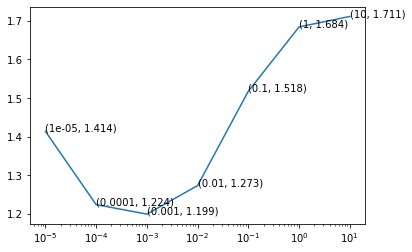

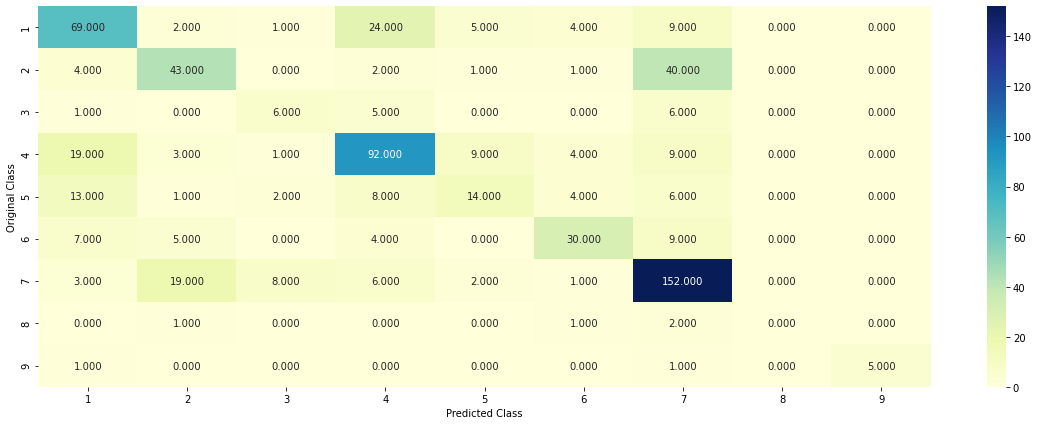

-------------------- Precision matrix (Columm Sum=1) --------------------


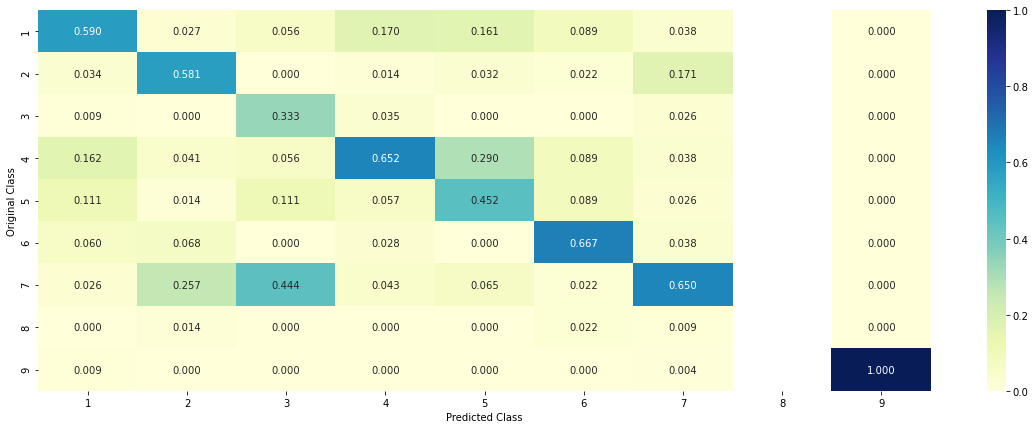

-------------------- Recall matrix (Row sum=1) --------------------


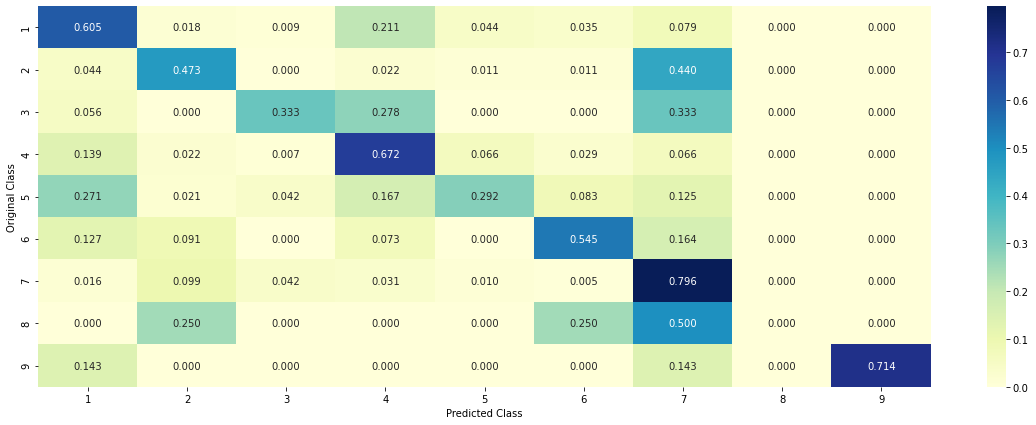

In [161]:
# Logistic classification With method='sigmoid' in CalibratedClassifierCV
log_loss_Logi = []
alphas = [10 ** x for x in range(-5,2)]
for alpha in tqdm(alphas):
    log_clf = SGDClassifier(loss='log',penalty='l2',alpha=alpha,random_state=99,n_jobs=-1)
    log_clf.fit(train_text_bow,trainy)
    log_calib = CalibratedClassifierCV(log_clf,method='sigmoid',cv='prefit')
    log_calib.fit(cv_text_bow,cvy)
    Y_predict_log = log_calib.predict_proba(test_text_bow)
    log_loss_Logi.append(log_loss(testy,Y_predict_log,eps=1e-15))
''' We should be doing the CV here as we are using the Y_test for getting the best apha which is totally wrong'''
print('Test log losses:',log_loss_Logi)
# plt.plot(alphas,log_loss_Logi) #matplotlib
# plt.show()
sns.lineplot(alphas,log_loss_Logi).set(xscale="log")
ax=plt.gca()
for i, txt in enumerate(np.round(log_loss_Logi,3)):
    ax.annotate((alphas[i],np.round(txt,3)), (alphas[i],log_loss_Logi[i]))

bst_alpha = alphas[log_loss_Logi.index(min(log_loss_Logi))]
bst_estimator_Logi = SGDClassifier(loss='log',penalty='l2',alpha=bst_alpha,random_state=99,n_jobs=-1)
bst_estimator_Logi.fit(train_text_bow,trainy)
bst_estimator_Logi_calib = CalibratedClassifierCV(bst_estimator_Logi,method='sigmoid',cv='prefit')
bst_estimator_Logi_calib.fit(cv_text_bow,cvy)
print('Best alpha:',bst_alpha)
print('Train Log-loss:',log_loss(trainy,bst_estimator_Logi_calib.predict_proba(train_text_bow),eps=1e-15))
print('CV Log-loss:',log_loss(cvy,bst_estimator_Logi_calib.predict_proba(cv_text_bow),eps=1e-15))
print('Test Log-loss:',log_loss(testy,bst_estimator_Logi_calib.predict_proba(test_text_bow),eps=1e-15))
plot_confusion_matrix(testy,bst_estimator_Logi.predict(test_text_bow))

<p style="font-size:18px;"> <b>Q.</b> Is the Text feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Yes, it seems like! </p>

In [132]:
t1_ex = extnWrds(trainx['txt'])
t2_ex = extnWrds(testx['txt'])
t3_ex = extnWrds(cvx['txt'])
print(np.round((len(set(t1_ex) & set(t2_ex))/len(set(t2_ex)))*100, 3), "% of word of test data appeared in train data")
print(np.round((len(set(t1_ex) & set(t3_ex))/len(set(t3_ex)))*100, 3), "% of word of cv data appeared in train data")

79.376 % of word of test data appeared in train data
78.976 % of word of cv data appeared in train data


The text feature looks stable, also it is the most important feature as it obtains best logloss score in Univariante models <br>
 Text : Test Log-loss: 1.1990956592875368<br>
 Gene : Test Log-loss: 1.2066079630582023<br>
 Variation : Test Log-loss: 1.722113275107996<br>

<h1>Machine Learning Models</h1>

- ### Getting Data READY

In [340]:
train_gene_ohe.shape,train_vari_ohe.shape,train_text_bow.shape

((2124, 227), (2124, 1951), (2124, 51985))

In [159]:
# One Hot Encoded Data
    #BOW
train_onehotCoding = hstack((train_gene_ohe,train_vari_ohe,train_text_bow)).tocsr()
test_onehotCoding = hstack((test_gene_ohe,test_vari_ohe,test_text_bow)).tocsr()
cv_onehotCoding = hstack((cv_gene_ohe,cv_vari_ohe,cv_text_bow)).tocsr()
    # tfIdf
train_onehotCoding2 = hstack((train_gene_ohe,train_vari_ohe,train_text_tfidf)).tocsr()
test_onehotCoding2 = hstack((test_gene_ohe,test_vari_ohe,test_text_tfidf)).tocsr()
cv_onehotCoding2 = hstack((cv_gene_ohe,cv_vari_ohe,cv_text_tfidf)).tocsr()

# Responce coded Data
train_responseCoding = hstack((train_gene_response,train_vari_response,sp.csr_matrix(train_text_response))).tocsr()
test_responseCoding = hstack((test_gene_response,test_vari_response,sp.csr_matrix(test_text_response))).tocsr()
cv_responseCoding = hstack((cv_gene_response,cv_vari_response,sp.csr_matrix(cv_text_response))).tocsr()

train_onehotCoding.shape,test_onehotCoding.shape,cv_onehotCoding.shape,train_onehotCoding2.shape,test_onehotCoding2.shape,cv_onehotCoding2.shape,train_responseCoding.shape,test_responseCoding.shape,cv_responseCoding.shape

((2124, 54163),
 (665, 54163),
 (532, 54163),
 (2124, 54163),
 (665, 54163),
 (532, 54163),
 (2124, 27),
 (665, 27),
 (532, 27))

So from this we can say that the responce coding generates faaaar more less dimentional data than the One Hot Encoding.<br>
So it is not an thumb rule but it is possible that for:<br>
NB,LogiReg,Lr-SVM => OneHotEncoder for large dimentional datasets<br>
K-NN,DT,RF => Response coding for small dimentional data<br>

## 1) The first model will be <br>
# Naive Bayes
Base line model<br>
&nbsp&nbsp&nbsp OneHotEncoding
### because as we have seen in NaiveBayes chapter it is an base model for text data model so....


100%|██████████| 7/7 [00:03&lt;00:00,  2.09it/s]
Test log losses: [1.2998133002563705, 1.2938364612813293, 1.3056660964054603, 1.3037864132972168, 1.3097786005109078, 1.2872817141002204, 1.4249370355475497]
Best alpha: 1
Train Log-loss: 0.9152422449473513
CV Log-loss: 1.2618122315937221
Test Log-loss: 1.2872817141002204
-------------------- Confusion matrix --------------------


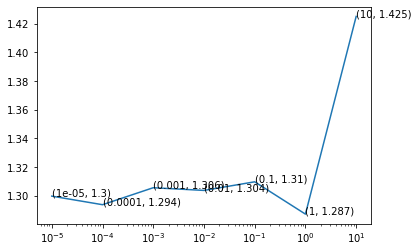

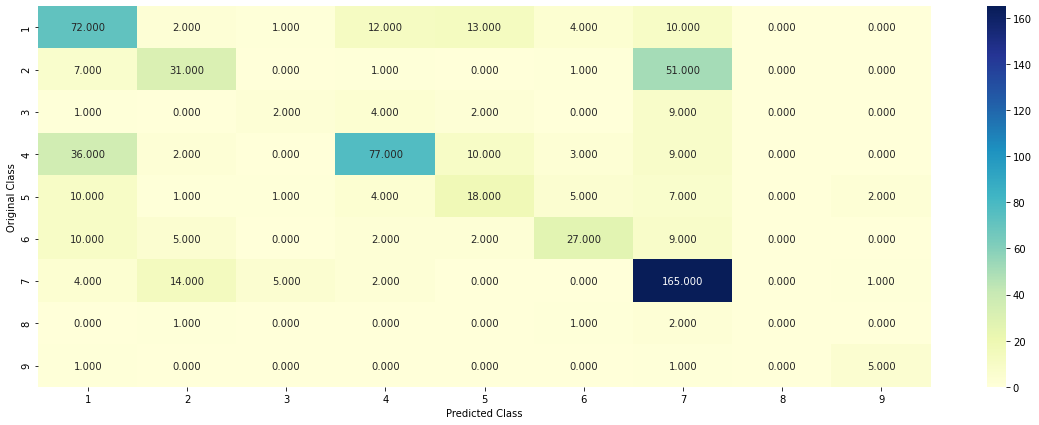

-------------------- Precision matrix (Columm Sum=1) --------------------


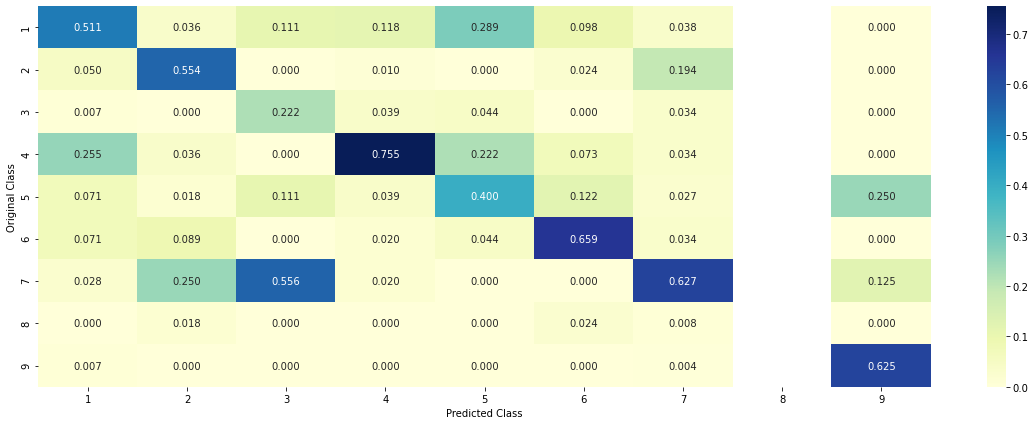

-------------------- Recall matrix (Row sum=1) --------------------


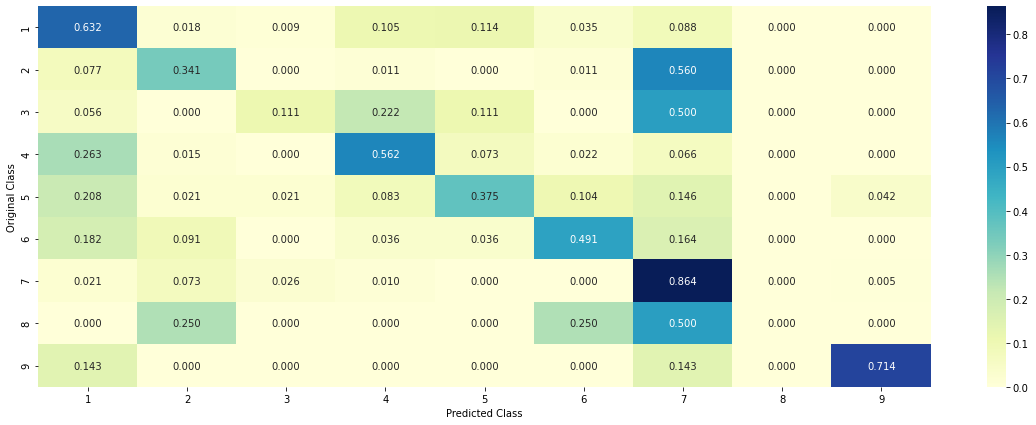

In [254]:
# MultinomialNB classification With method='sigmoid' in CalibratedClassifierCV
log_loss_Logi = []
alphas = [10 ** x for x in range(-5,2)]
for alpha in tqdm(alphas):
    log_clf = MultinomialNB(alpha=alpha)
    # log_clf.fit(train_onehotCoding,trainy)
    # log_calib = CalibratedClassifierCV(log_clf,method='sigmoid',prefit=True)
    # log_calib.fit(cv_onehotCoding,cvy)
    # --------------------------------
    log_calib = CalibratedClassifierCV(log_clf,method='sigmoid')
    log_calib.fit(train_onehotCoding,trainy)
    # --------------------------------
    Y_predict_log = log_calib.predict_proba(test_onehotCoding)
    log_loss_Logi.append(log_loss(testy,Y_predict_log,eps=1e-15))
print('Test log losses:',log_loss_Logi)
# plt.plot(alphas,log_loss_Logi) #matplotlib
# plt.show()
sns.lineplot(alphas,log_loss_Logi).set(xscale="log")
ax=plt.gca()
for i, txt in enumerate(np.round(log_loss_Logi,3)):
    ax.annotate((alphas[i],np.round(txt,3)), (alphas[i],log_loss_Logi[i]))

bst_alpha = alphas[np.argmin(log_loss_Logi)]
bst_estimator_Logi = MultinomialNB(alpha=bst_alpha)
# bst_estimator_Logi.fit(train_onehotCoding,trainy)
# bst_estimator_Logi_calib = CalibratedClassifierCV(bst_estimator_Logi,method='sigmoid',prefit=True)
# bst_estimator_Logi_calib.fit(cv_onehotCoding,cvy)
# --------------------------
bst_estimator_Logi_calib = CalibratedClassifierCV(bst_estimator_Logi,method='sigmoid')
bst_estimator_Logi_calib.fit(train_onehotCoding,trainy)
bst_estimator_Logi.fit(train_onehotCoding,trainy)
# --------------------------
print('Best alpha:',bst_alpha)
print('Train Log-loss:',log_loss(trainy,bst_estimator_Logi_calib.predict_proba(train_onehotCoding),eps=1e-15))
print('CV Log-loss:',log_loss(cvy,bst_estimator_Logi_calib.predict_proba(cv_onehotCoding),eps=1e-15))
print('Test Log-loss:',log_loss(testy,bst_estimator_Logi_calib.predict_proba(test_onehotCoding),eps=1e-15))
plot_confusion_matrix(testy,bst_estimator_Logi.predict(test_onehotCoding))

In [255]:
#Miss-classified points
print('Number of miss-classified points:')
sum(bst_estimator_Logi_calib.predict(test_onehotCoding)!=testy)/len(testy)

Number of miss-classified points:


0.39097744360902253

In [432]:
ohebow_feat_names = np.array(list(OHE_gene.get_feature_names())+list(OHE_vari.get_feature_names())+bow_vectorizer.get_feature_names())
def briefAna(rowno,a):
    pred_y = bst_estimator_Logi.predict(test_onehotCoding[rowno])
    print('Actual Y:',testy.iloc[rowno])
    print('Predicted Y:',pred_y)
    print('Predicted Probability:',bst_estimator_Logi_calib.predict_proba(test_onehotCoding[rowno]))
    indice = np.argsort(-1*abs(bst_estimator_Logi.coef_))[pred_y-1][:,-a:]
    # print(indice[0])
    feat_list = [x for x in indice[0] if test_onehotCoding[rowno,x]!=0.0]
    for i in ohebow_feat_names[feat_list]: print(i) # returns the intresection of top important features for the class predicted by the model for the point and the fretures present in the point
    return ohebow_feat_names[feat_list]

The point below is an correctly classified point, the list of features are of the top 100 imp. features of class 7 that are present in the point

In [433]:
briefAna(0,100);

Actual Y: 7
Predicted Y: [7]
Predicted Probability: [[0.06642583 0.08598021 0.02220757 0.10084401 0.04897465 0.0356368
  0.62976064 0.00641963 0.00375066]]
detected
therapeutic
due
increased
sensitive
mutation
mechanism
furthermore
could
two
inhibition
inhibitors
either
reported
fig
occur
small
proliferation
molecular
phosphorylation
another
activated
three
recent
different
15
identified
figure
various
although
respectively
approximately
consistent
new
interestingly
using
without
confirmed
studies
1a
including
12
total
observed
addition
treated
mutations
obtained
described
higher
potential
may
growth
suggest
found
10
activation
cells
similar
factor
contrast
cell
previously
inhibitor
expressing
independent
however
shown
compared
also
showed
recently
well
kinase
downstream
activating
presence
x0_PDGFRA


now lets see an incorrectly classified point

In [434]:
briefAna(2,100);

Actual Y: 4
Predicted Y: [1]
Predicted Probability: [[0.47146869 0.21302205 0.02455756 0.11359882 0.05417353 0.03958198
  0.07230659 0.00708346 0.00420732]]
efficiency
eight
change
whereas
specificity
significant
likely
multiple
shown
within
may
table
coding
role
located
changes
critical
contains
indicate
important
additional
determined
expected
previous
identify
data
structure
remaining
also
many
five
results
proteins
ability
specific
genetic
using
define
least
used
indicating
form
surface
therefore
result
effect
six
three
gene
remains
corresponding
large
identified
terminal
present
essential
conserved
sequences
containing
analysis
loss
possible
functions
region
amino
four
involved
sequence
affect
reduced
binding
two
wild
dna
protein
one
function
type


Now the above list is one of the imp features of class 1 that are present in that partcular point.
here you can see that the point has been miss-classified.
## Now why the above function is important?
### The above function is very important because it provedes interpretablity as for what feature contributed to the factor of predicting an particular class. Also you can see that in the first correctly classified point the probability is strong and hence the prediction can be considered credible, but in the second miss-classified point the probability is not strong for class 1, so now the doctors can look presonaly.
## Hence it provides INTREPRETABILITY

# 2) K-NN 
&nbsp&nbsp&nbsp ResponceCoding
### We will use responce coding because knn does not work well with high dimentional data


100%|██████████| 20/20 [00:02&lt;00:00,  6.86it/s]
Test log losses: [1.8306376175774843, 1.1084285586809217, 1.0969750637645868, 1.0996600242471166, 1.1008496707938464, 1.1117719544154754, 1.116418525587254, 1.1184316619419863, 1.1160867004552457, 1.1169991681838305, 1.1153303976159419, 1.1188844849996054, 1.1198342444054017, 1.1203288902009447, 1.1239581084450048, 1.12542010980564, 1.1284868858375496, 1.1282322221369179, 1.1317258254993239, 1.1334359758880714]
Best alpha: 10
Train Log-loss: 0.6269290003829089
CV Log-loss: 1.0150511577703054
Test Log-loss: 1.0969750637645868
-------------------- Confusion matrix --------------------


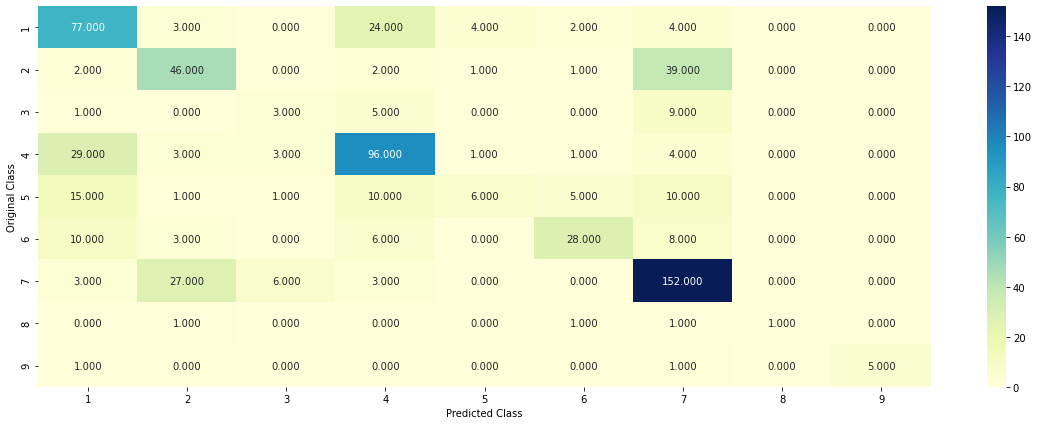

-------------------- Precision matrix (Columm Sum=1) --------------------


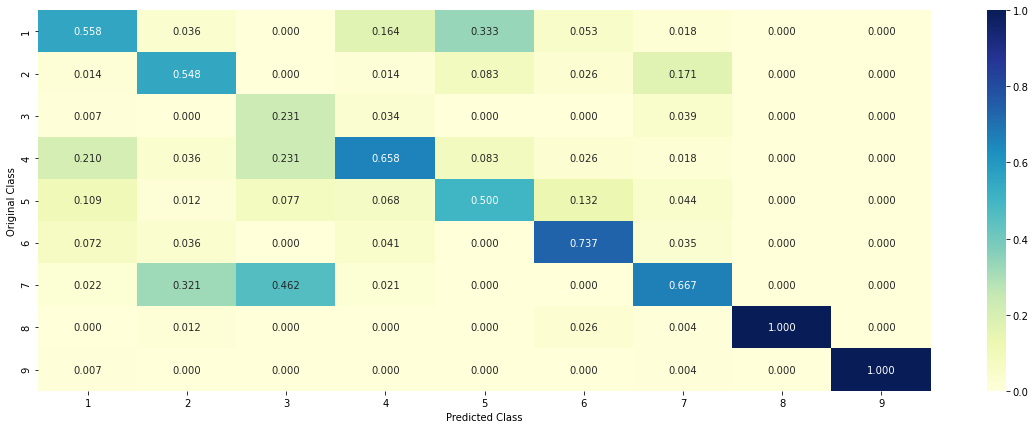

-------------------- Recall matrix (Row sum=1) --------------------


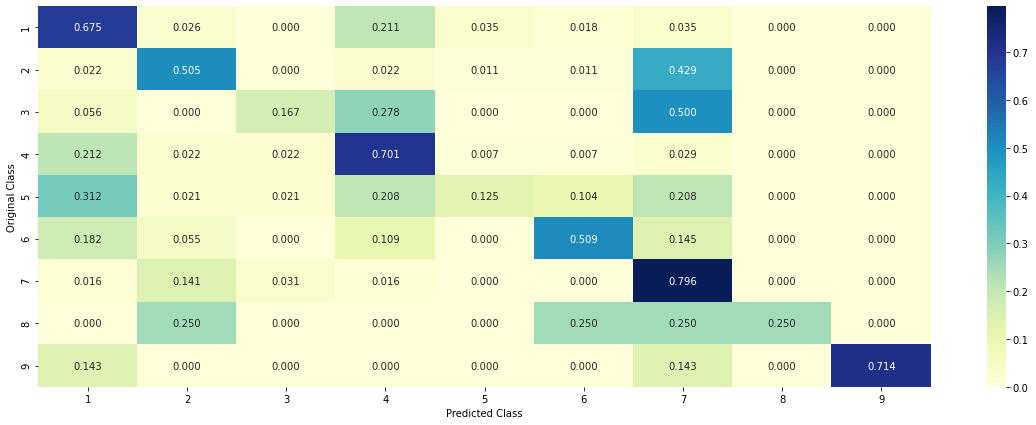

In [466]:
# MultinomialNB classification With method='sigmoid' in CalibratedClassifierCV
log_loss_Logi = []
alphas = [x for x in range(0,100,5)]
for alpha in tqdm(alphas):
    log_clf = KNeighborsClassifier(n_neighbors=alpha)
    log_clf.fit(train_responseCoding,trainy)
    log_calib = CalibratedClassifierCV(log_clf,method='sigmoid',cv='prefit')
    log_calib.fit(cv_responseCoding.toarray(),cvy)
    # --------------------------------
    # log_calib = CalibratedClassifierCV(log_clf,method='sigmoid')
    # log_calib.fit(train_responseCoding,trainy)
    # --------------------------------
    Y_predict_log = log_calib.predict_proba(test_responseCoding)
    log_loss_Logi.append(log_loss(testy,Y_predict_log,eps=1e-15))
print('Test log losses:',log_loss_Logi)
# plt.plot(alphas,log_loss_Logi) #matplotlib
# plt.show()
# fig = plt.figure(figsize=(9,9))
# sns.lineplot(alphas,log_loss_Logi).set(xscale="log")
# ax=plt.gca()                                              # Here the code is throwing error
# for i, txt in enumerate(np.round(log_loss_Logi,3)):
#     ax.annotate((alphas[i],np.round(txt,3)), (alphas[i],log_loss_Logi[i]))

bst_alpha = alphas[np.argmin(log_loss_Logi)]
bst_estimator_Logi = KNeighborsClassifier(n_neighbors=bst_alpha)
bst_estimator_Logi.fit(train_responseCoding,trainy)
bst_estimator_Logi_calib = CalibratedClassifierCV(bst_estimator_Logi,method='sigmoid',cv='prefit')
bst_estimator_Logi_calib.fit(cv_responseCoding,cvy)
# --------------------------
# bst_estimator_Logi_calib = CalibratedClassifierCV(bst_estimator_Logi,method='sigmoid')
# bst_estimator_Logi_calib.fit(train_responseCoding,trainy)
# bst_estimator_Logi.fit(train_responseCoding,trainy)
# --------------------------
print('Best alpha:',bst_alpha)
print('Train Log-loss:',log_loss(trainy,bst_estimator_Logi_calib.predict_proba(train_responseCoding),eps=1e-15))
print('CV Log-loss:',log_loss(cvy,bst_estimator_Logi_calib.predict_proba(cv_responseCoding),eps=1e-15))
print('Test Log-loss:',log_loss(testy,bst_estimator_Logi_calib.predict_proba(test_responseCoding),eps=1e-15))
plot_confusion_matrix(testy,bst_estimator_Logi.predict(test_responseCoding))

In [467]:
print('Number of miss-classified points:')
sum(bst_estimator_Logi_calib.predict(test_responseCoding)!=testy)/len(testy)

Number of miss-classified points:


0.38345864661654133

In [509]:
def nearstNeigh(rowno):
    print('Actuall Y:',testy.iloc[rowno])
    print('Predicted Y:',bst_estimator_Logi.predict(test_responseCoding[rowno]))
    print('Predicted Probability:',bst_estimator_Logi_calib.predict_proba(test_responseCoding[rowno]))
    tem = bst_estimator_Logi.predict(train_responseCoding[bst_estimator_Logi.kneighbors(test_responseCoding[rowno])[1][0]])
    print('Nearst Neigh on basis of which the model made it\'s decision',tem)
    print('Frequency of nearst points:',Counter(tem))

In [510]:
nearstNeigh(2)

Actuall Y: 4
Predicted Y: [2]
Predicted Probability: [[0.23013957 0.36750299 0.02399858 0.16923715 0.10157867 0.03514715
  0.06150582 0.00575169 0.00513836]]
Nearst Neigh on basis of which the model made it&#39;s decision [1 2 1 2 4 2 2 1 4 1]
Frequency of nearst points: Counter({1: 4, 2: 4, 4: 2})


## Now why the above function is important?
## Again for -> INTREPRETABILITY